In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import pickle
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
#import func_draw_GRN
#import Modular_param_search
import atlas
import atlas_original
import seaborn as sns

# Functions and Parameters

## 0.1. Fixed Parameters

In [63]:
N = 2
tf = 1000
dt_neur = 0.001
t_neur = np.arange(0, tf, dt_neur)
dt_gene = 0.1
t_gene = np.arange(0, tf, dt_gene)

## 0.2. Functions

In [64]:
def feat_norm(features):
    '''
    Feature normalization
    '''
    feat_norm = zscore(features)
    return feat_norm

In [65]:
def save_df(file_name, df):
    '''
    Function for saving a dataframe
    '''
    # open a file, where you ant to store the data
    file = open(file_name, 'wb')
    # dump information to that file
    pickle.dump(df, file)
    # close the file
    file.close()

def load_df(file_name):
    '''
    Function for loading a dataframe
    '''
    # open a file, where you stored the pickled data
    file = open(file_name, 'rb')
    # dump information to that file
    data = pickle.load(file)
    # close the file
    file.close()
    return data

In [66]:
#FUNCTIONS THAT FIX THE PROBLEMS OF OUR DF (these problems will be fixed in future versions of data but since it takes long time for it to be computed, 
                                           # it is easier to solve them like this for the moment)
def change_ext_input_names(df):
    '''
    Change external input relations from 0, 1, 2 to +r, -r, nd
    '''
    arr = np.stack(df['External input proportionality'].values)
    mask_0 = (arr==0)
    mask_1 = (arr==1)
    mask_2 = (arr==2)
    
    arr2 = np.zeros((arr.shape)).astype('<U2')
    arr2[mask_0] = '+r'
    arr2[mask_1] = '-r'
    arr2[mask_2] = 'nd'
    
    df['External input proportionality'] = pd.Series(arr2.tolist())
    return df

In [67]:
def create_traj_to_plot(N, df, n_samp_sq):
    cluster_list = df.index.values
    random.shuffle(cluster_list)
    random_cluster_list = cluster_list[0:n_samp_sq**2]
    print(random_cluster_list)
    param_sets = []
    ext_inputs = []
    ics = []
    V_all = np.zeros((n_samp_sq**2, len(t_gene)))
    V_th_all = np.zeros((n_samp_sq**2, len(t_gene)))
    genes_all_base = np.zeros((n_samp_sq**2, N, len(t_gene)))
    genes_all_spike = np.zeros((n_samp_sq**2, N, len(t_gene)))
    for i, index in enumerate(random_cluster_list):
        param_set = df['Parameter set'][index]
        ext_input = df['External input proportionality'][index]
        ic = df['Initial conditions'][index]
        param_sets.append(param_set)
        ext_inputs.append(ext_input)
        ics.append(ic)
        
        V, V_th, gene_conc_spike, gene_conc_base,  gene_conc_dev, spike = atlas_original.coupled_system(N, param_sets[i], ext_inputs[i], ics[i])
        reduce_V_mask = np.arange(0, tf*1000, dt_neur*1000)%100==0
        V_all[i, :] = V[reduce_V_mask]
        V_th_all[i, :] = V_th[reduce_V_mask]
        genes_all_base[i, :, :] = gene_conc_base
        genes_all_spike[i, :, :] = gene_conc_spike
                
    return (V_all, V_th_all, genes_all_spike, genes_all_base, param_sets, ext_inputs, ics, random_cluster_list)

def make_traj_grid_plots(V_all, V_th_all, genes_all, param_sets, ext_inputs, ics, title, what, n_samp_sq, random_cluster_list):
    fig, axs = plt.subplots(nrows=n_samp_sq, ncols=n_samp_sq, figsize=(20, 15), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title, fontsize=20, y=0.95)
    row = 0
    col = 0
    for obs in range(n_samp_sq**2):
        if col>=n_samp_sq:
            row = row + 1
            col = 0
        par = param_sets[obs]
        if what == 'gene':
            axs[row, col].plot(t_gene, genes_all[obs, 0, :])
            axs[row, col].plot(t_gene, genes_all[obs, 1, :])
            axs[row, col].set_title(obs, fontsize = 18)
            axs[-1, col].set_xlabel("$t$", fontsize = 18)
            axs[row, 0].set_ylabel("$g_{conc}$", fontsize = 18)
            axs[row, col].set_ylim(-2, 22)
        else:
            axs[row, col].plot(t_gene[:-1], V_all[obs, :-1], c = 'mediumseagreen')
            axs[row, col].plot(t_gene[:-1], V_th_all[obs, :-1], c = 'r')
            axs[row, col].set_title(obs, fontsize = 18)
            axs[-1, col].set_xlabel("$t$", fontsize = 18)
            axs[row, 0].set_ylabel("$V$ and $V_{th}$", fontsize = 18)
        axs[n_samp_sq-1, col].tick_params(axis='x', labelsize=15)
        axs[row, 0].tick_params(axis='y', labelsize=16)
        
        col = col + 1
    plt.show()

In [68]:
def reshape_df_to_all_ic(df, scaled_features):
    df_all_ic = pd.DataFrame(data=None, index=None, columns=['Network topology', 'Parameter set', 'External input proportionality', 'Features'], dtype=None, copy=None)
    new_features = np.zeros((int(scaled_features.shape[0]/25), scaled_features.shape[1]*25))
    for i in range(int(scaled_features.shape[0]/25)):
        new_features[i] = scaled_features[(i*25):25+(i*25)].reshape(1, scaled_features.shape[1]*25)
        new_row_df = {'Network topology':df['Network topology'][i*25], 'Parameter set':df['Parameter set'][i*25], 'External input proportionality':df['External input proportionality'][i*25], 'Features': new_features[i]}
        df_all_ic.loc[len(df_all_ic)] = new_row_df 
    return(df_all_ic, new_features)

In [69]:
def create_traj_to_plot_all_ic(N, df, cluster_labels, cluster_number, ic_list):
    ic_combinations = np.array(list(itertools.product(ic_list, repeat = N)))
    cluster_list = np.where(cluster_labels == cluster_number)[0]
    random.shuffle(cluster_list)
    random_cluster_list = cluster_list[0:10]
    print(random_cluster_list)
    param_sets = []
    ext_inputs = []

    V_all = np.zeros((10, 25, len(t_gene)))
    V_th_all = np.zeros((10, 25, len(t_gene)))
    genes_all_base = np.zeros((10, 25, 2, len(t_gene)))
    genes_all_spike = np.zeros((10, 25, 2, len(t_gene)))

    for i, index in enumerate(random_cluster_list):
        param_set = df['Parameter set'][index]
        ext_input = df['External input proportionality'][index]
        param_sets.append(param_set)
        ext_inputs.append(ext_input)
        
        for j, ic in enumerate(ic_combinations):
            V, V_th, gene_conc_spike, gene_conc_base,  gene_conc_dev, spike = atlas_original.coupled_system(N, param_sets[i], ext_inputs[i], ic)
            reduce_V_mask = np.arange(0, tf*1000, dt_neur*1000)%100==0
            V_all[i, j, :] = V[reduce_V_mask]
            V_th_all[i, j, :] = V_th[reduce_V_mask]
            genes_all_base[i, j, :, :] = gene_conc_base
            genes_all_spike[i, j, :, :] = gene_conc_spike
                
    return (V_all, V_th_all, genes_all_spike, genes_all_base, param_sets, ext_inputs)

def make_traj_grid_plots_all_ic(V_all, V_th_all, genes_all, param_sets, ext_inputs, title, what, ic_list):
    ic_combinations = np.array(list(itertools.product(ic_list, repeat = N)))

    fig, axs = plt.subplots(nrows=V_all.shape[1], ncols=V_all.shape[0], figsize=(25, 35), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title, fontsize=18, y=0.95)
    
    for par in range(V_all.shape[0]):
        for ic in range(V_all.shape[1]):
            if what == 'gene':
                axs[ic, par].plot(t_gene, genes_all[par, ic, 0, :])
                axs[ic, par].plot(t_gene, genes_all[par, ic, 1, :])
                axs[ic, 4].set_title(ic_combinations[ic])
                axs[-1, par].set_xlabel("$t$")
                axs[ic, 0].set_ylabel("$g_{conc}$")
                axs[ic, par].set_ylim(-2, 22)
            else:
                axs[ic, par].plot(t_gene[:-1], V_all[par, ic, :-1], c = 'mediumseagreen')
                axs[ic, par].plot(t_gene[:-1], V_th_all[par, ic, :-1], c = 'r')
                axs[ic, 4].set_title(ic_combinations[ic])
                axs[-1, par].set_xlabel("$t$")
                axs[ic, 0].set_ylabel("$V$ and $V_{th}$")
    plt.show()

# RESULTS

## 1. Create and Load Dataframe

In [70]:
# Load a dataframe + visualize it
array_features = np.load('features_array_2507_features.npy')
array_features

array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        7.24000000e-01, 1.26895334e+01, 1.13005877e+01],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        7.24000000e-01, 1.26895334e+01, 1.13005877e+01],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        7.24000000e-01, 1.26895334e+01, 1.13005877e+01],
       ...,
       [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, ...,
        1.99930000e+01, 8.40940342e-03, 7.33788952e+00],
       [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, ...,
        1.99930000e+01, 8.40940342e-03, 7.33788952e+00],
       [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, ...,
        1.99930000e+01, 8.40940342e-03, 7.33788952e+00]])

feats = np.zeros((array_features.shape[0],3))
sum_fluct = np.sum(array_features[:,13:15], axis=1)
feats[:, [0,2]] = array_features[:,[12,15]]
feats[:, 1] = sum_fluct

In [71]:
data = {
    'Network topology': list(array_features[:, 0:4]),
    'Parameter set': list(array_features[:, 4:8]),
    'External input proportionality': list(array_features[:, 8:10]), 
    'Initial conditions': list(array_features[:, 10:12]), 
    'Features': list(array_features[:,12])
}

In [72]:
df = pd.DataFrame(data=data)

In [73]:
df = change_ext_input_names(df)
df

,Network topology,Parameter set,External input proportionality,Initial conditions,Features
0,"[0.0, 1.0, 0.0, 0.0]","[0.0, 3.249600073299126, 0.0, 0.0]","[+r, +r]","[0.0, 0.0]",6541.0
1,"[0.0, 1.0, 0.0, 0.0]","[0.0, 3.249600073299126, 0.0, 0.0]","[+r, +r]","[0.0, 5.0]",6541.0
2,"[0.0, 1.0, 0.0, 0.0]","[0.0, 3.249600073299126, 0.0, 0.0]","[+r, +r]","[0.0, 10.0]",6541.0
3,"[0.0, 1.0, 0.0, 0.0]","[0.0, 3.249600073299126, 0.0, 0.0]","[+r, +r]","[0.0, 15.0]",6541.0
4,"[0.0, 1.0, 0.0, 0.0]","[0.0, 3.249600073299126, 0.0, 0.0]","[+r, +r]","[0.0, 20.0]",6541.0
...,...,...,...,...,...
389995,"[2.0, 2.0, 2.0, 2.0]","[-1.8724634395220625, -2.213427353297178, -1.0...","[nd, -r]","[20.0, 0.0]",6906.0
389996,"[2.0, 2.0, 2.0, 2.0]","[-1.8724634395220625, -2.213427353297178, -1.0...","[nd, -r]","[20.0, 5.0]",6906.0
389997,"[2.0, 2.0, 2.0, 2.0]","[-1.8724634395220625, -2.213427353297178, -1.0...","[nd, -r]","[20.0, 10.0]",6906.0
389998,"[2.0, 2.0, 2.0, 2.0]","[-1.8724634395220625, -2.213427353297178, -1.0...","[nd, -r]","[20.0, 15.0]",6906.0


In [74]:
features = np.stack(df['Features'].values)
scaled_features = zscore(features)

In [75]:
# Calculate the minimum value for each column
min_val = np.min(features, axis=0)

# Calculate the maximum value for each column
max_val = np.max(features, axis=0)

# Apply min-max normalization
normalized_features = (features - min_val) / (max_val - min_val)

In [76]:
scaled_features = scaled_features
normalized_features = normalized_features

In [77]:
features = df['Features'].values
np.stack(features)

array([6541., 6541., 6541., ..., 6906., 6906., 6906.])

In [78]:
features = np.stack(df['Features'].values)
scaled_features = zscore(features)
scaled_features# = np.reshape(scaled_features, (len(scaled_features), 1))
#scaled_features2 = scaled_features[:, [0,2]]
#scaled_features3 = scaled_features[:, [0,1]]
#scaled_features3

array([-0.42271576, -0.42271576, -0.42271576, ...,  0.21546468,
        0.21546468,  0.21546468])

normalized_features = np.stack(df['Features'].values)
normalized_features = normalized_features/np.max(normalized_features)
#normalized_features[:, 1]= normalized_features[:, 1]/np.max(normalized_features[:, 1])
#normalized_features2 = normalized_features[:, [0,2]]
#normalized_features3 = normalized_features[:, [0,1]]

## 2. All initial conditions together in the same observation

### 2.1. Reshaping our dataframe and features

In [79]:
scaled_features = scaled_features.reshape((scaled_features.shape[0], 1))

In [80]:
df_all_ic, new_features = reshape_df_to_all_ic(df, scaled_features)

In [81]:
df_all_ic

,Network topology,Parameter set,External input proportionality,Features
0,"[0.0, 1.0, 0.0, 0.0]","[0.0, 3.249600073299126, 0.0, 0.0]","[+r, +r]","[-0.42271575728222655, -0.42271575728222655, -..."
1,"[0.0, 1.0, 0.0, 0.0]","[0.0, 3.249600073299126, 0.0, 0.0]","[+r, -r]","[0.10181610956752954, 0.10181610956752954, 0.1..."
2,"[0.0, 1.0, 0.0, 0.0]","[0.0, 3.249600073299126, 0.0, 0.0]","[+r, nd]","[0.5651525919514808, 0.5651525919514808, 0.565..."
3,"[0.0, 1.0, 0.0, 0.0]","[0.0, 3.249600073299126, 0.0, 0.0]","[-r, +r]","[-0.4576845484055436, -0.4576845484055436, -0...."
4,"[0.0, 1.0, 0.0, 0.0]","[0.0, 3.249600073299126, 0.0, 0.0]","[-r, -r]","[-0.4489423506247144, -0.4489423506247144, -0...."
...,...,...,...,...
15595,"[2.0, 2.0, 2.0, 2.0]","[-1.8724634395220625, -2.213427353297178, -1.0...","[-r, +r]","[0.21546468071831004, 0.21546468071831004, 0.2..."
15596,"[2.0, 2.0, 2.0, 2.0]","[-1.8724634395220625, -2.213427353297178, -1.0...","[-r, -r]","[0.21546468071831004, 0.21546468071831004, 0.2..."
15597,"[2.0, 2.0, 2.0, 2.0]","[-1.8724634395220625, -2.213427353297178, -1.0...","[-r, nd]","[0.21546468071831004, 0.21546468071831004, 0.2..."
15598,"[2.0, 2.0, 2.0, 2.0]","[-1.8724634395220625, -2.213427353297178, -1.0...","[nd, +r]","[0.2854022629649442, 0.2854022629649442, 0.285..."


In [82]:
df_all_ic.loc[13246]

Network topology                                               [1.0, 2.0, 1.0, 2.0]
Parameter set                     [3.348254217512439, -1.8792814715403707, 1.358...
External input proportionality                                             [nd, +r]
Features                          [0.3990508341157247, 0.3990508341157247, 0.399...
Name: 13246, dtype: object

## 3. Performing hierarchical clustering, visualization of the truncated dendogram

In [83]:
import numpy as np
from scipy.cluster.hierarchy import linkage

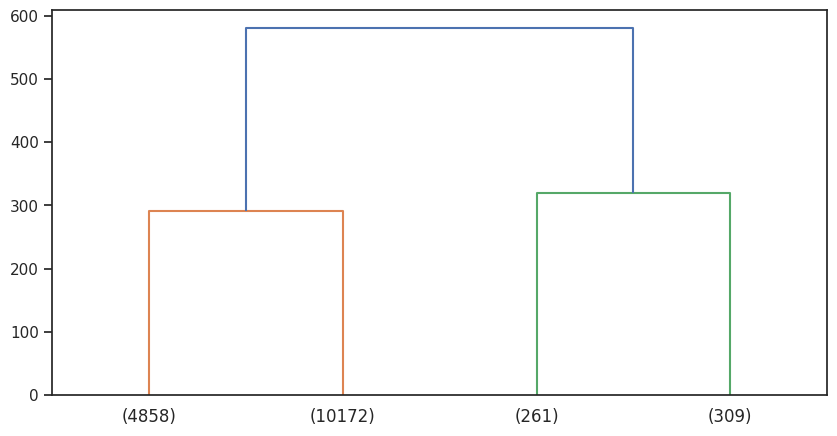

In [84]:
plt.figure(figsize=(10,5))
ward_clustering_2 = linkage(new_features, method="ward", metric="euclidean")
R2 = dendrogram(ward_clustering_2, p = 4, truncate_mode = 'lastp')
plt.show()

### 3.1. Selecting a threshold distance for the clusters and obtaining our labels

In [85]:
# Choose a threshold distance based on the dendrogram
threshold_distance = 400

# Cut the dendrogram to get cluster labels
cluster_labels = fcluster(ward_clustering_2, threshold_distance, criterion='distance')

In [86]:
np.unique(cluster_labels, return_counts=True)

(array([1, 2], dtype=int32), array([15030,   570]))

In [87]:
cluster_labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

## 4. Analysis
Let's try to identify patterns in the clustering:

1) Do similar topologies with different sets of parameters each behave in the same way (do they belong to the same cluster)?
2) Do different topologies with same initial conditions behave in the same way?

In [88]:
def histogram_analysis(list_dep_combinations, learn_dep, learn_dep_counts):
    list_hist_dep = np.arange(0, list_dep_combinations.shape[0], 1)
    list_hist_dep_counts = np.zeros(list_dep_combinations.shape[0])
    for j, learn_pair in enumerate(learn_dep):
        learn_pair_counts = learn_dep_counts[j]
        for i, pair in enumerate(list_dep_combinations):
            if np.all(learn_pair == pair):
                list_hist_dep_counts[i] = learn_pair_counts
    return(list_hist_dep, list_hist_dep_counts)

def change_labels_dep():
    pos = np.array(('+r', '-r', 'nd'))
    comb = []
    for p1 in pos:
        for p2 in pos:
            comb.append(p1+', '+p2)
    return comb

def change_labels_net(all_net):
    lab = []
    for line in all_net:
        #line[line==2] = -1
        lab.append(f'{line}')
    return lab


def change_labels_both(all_net):
    lab = []
    for line in all_net:
        #line[line==2] = -1
        line = ', '.join(line)
        lab.append(f'{line}')
    return lab

#### 4.1. Cluster 1: No Habituation

In [89]:
MY_CLUSTER = 1
my_labels = cluster_labels




### for histograms that focus on the external dependence of genes on neurons ###
list_dep_combinations = np.array(list(itertools.product(np.array(('+r', '-r', 'nd')), np.array(('+r', '-r', 'nd')))))[:-1]
learn_dep, learn_dep_counts = np.unique(df_all_ic.iloc[my_labels==MY_CLUSTER]['External input proportionality'], return_counts=True)

list_hist_dep, list_hist_dep_counts = histogram_analysis(list_dep_combinations, learn_dep, learn_dep_counts)

comb = change_labels_dep()




### for histograms that focus on the parameter set for the GRN ###
all_net = np.unique(np.stack(df_all_ic['Network topology'].values), axis = 0)

net = df_all_ic.iloc[my_labels==MY_CLUSTER]['Network topology'].values
learn_net, learn_net_counts = np.unique(np.stack(net), axis = 0, return_counts=True)

list_hist_net, list_hist_net_counts = histogram_analysis(all_net, learn_net, learn_net_counts)

lab = change_labels_net(all_net)

In [90]:
MY_CLUSTER = 2
my_labels = cluster_labels


### for histograms that focus on the external dependence of genes on neurons ###
learn_dep, learn_dep_counts = np.unique(df_all_ic.iloc[my_labels==MY_CLUSTER]['External input proportionality'], return_counts=True)

list_hist_dep, list_hist_dep_counts_habit = histogram_analysis(list_dep_combinations, learn_dep, learn_dep_counts)
comb_habit = change_labels_dep()

### for histograms that focus on the parameter set for the GRN ###
net = df_all_ic.iloc[my_labels==MY_CLUSTER]['Network topology'].values
learn_net, learn_net_counts = np.unique(np.stack(net), axis = 0, return_counts=True)

list_hist_net, list_hist_net_counts_habit = histogram_analysis(all_net, learn_net, learn_net_counts)
lab_habit = change_labels_net(all_net)

In [91]:
df_ = df_all_ic.copy(deep=True)
df_['Network topology'] = df_all_ic['Network topology'].apply(lambda x: f'{x}')
df_['External input proportionality'] = df_all_ic['External input proportionality'].apply(lambda x: ', '.join(map(str, x)))

In [92]:
df_no_hab = df_.iloc[my_labels==1]
counts_no_hab = df_no_hab.groupby(['Network topology', 'External input proportionality']).size().reset_index(name='Count')

df_hab = df_.iloc[my_labels==2]
counts_hab = df_hab.groupby(['Network topology', 'External input proportionality']).size().reset_index(name='Count')
counts_no_hab_subset = counts_no_hab[['Network topology', 'External input proportionality']]
counts_hab_subset = counts_hab[['Network topology', 'External input proportionality']]
missing_rows = counts_no_hab[~counts_no_hab_subset.apply(tuple, axis=1).isin(counts_hab_subset.apply(tuple, axis=1))]
missing_rows['Count'] = 0
counts_hab_all = pd.concat([counts_hab, missing_rows], ignore_index=True)

/tmp/ipykernel_908/1998518046.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['Count'] = 0


In [93]:
data_barplot_extinput
data_barplot_extinput['GRN external inputs'] = data_barplot_extinput['GRN external inputs'].str.replace('nd', '0')
data_barplot_extinput

,GRN external inputs,Counts non-habituation,Counts habituation
7,"0, -r",1771.0,179.0
4,"-r, -r",1780.0,170.0
5,"-r, 0",1826.0,124.0
1,"+r, -r",1913.0,37.0
3,"-r, +r",1921.0,29.0
0,"+r, +r",1931.0,19.0
6,"0, +r",1941.0,9.0
2,"+r, 0",1947.0,3.0


/tmp/ipykernel_908/1512582692.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


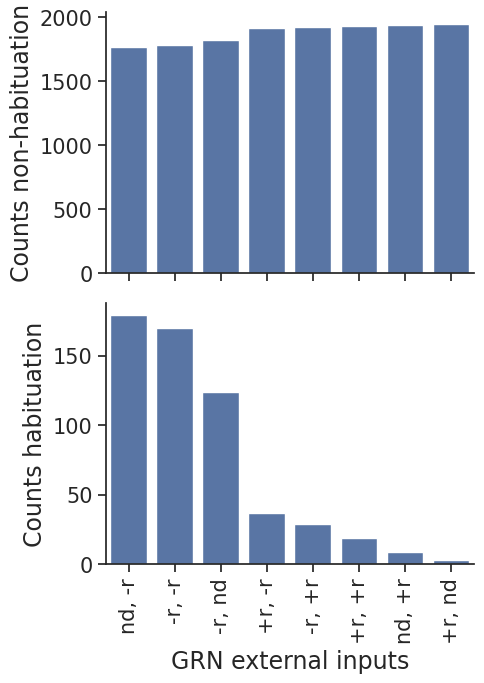

In [101]:
data_barplot_extinput = pd.DataFrame({
    'GRN external inputs': comb[:-1],
    'Counts non-habituation': list_hist_dep_counts, 
    'Counts habituation': list_hist_dep_counts_habit
})
data_barplot_extinput = data_barplot_extinput.sort_values(by='Counts habituation', ascending=False)
#data_barplot_extinput['GRN external inputs'] = data_barplot_extinput['GRN external inputs'].str.replace('nd', '0')

fig, axes = plt.subplots(2, 1, figsize=(5, 7))
sns.barplot(x='GRN external inputs', y='Counts non-habituation', data=data_barplot_extinput, ax=axes[0], )
sns.barplot(x='GRN external inputs', y='Counts habituation', data=data_barplot_extinput, ax=axes[1])
sns.set_theme(style="ticks")
axes[0].set_xticklabels([])
axes[0].set_xlabel('')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_xlabel('GRN external inputs', fontsize = 17)
axes[0].set_ylabel('Counts non-habituation', fontsize = 17)
axes[1].set_ylabel('Counts habituation', fontsize = 17)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)
sns.despine(ax=axes[0])
sns.despine(ax=axes[1])
plt.tight_layout()
plt.show()

In [102]:
data_barplot_network = pd.DataFrame({
    'Network topology': lab,
    'Counts non-habituation': list_hist_net_counts, 
    'Counts habituation': list_hist_net_counts_habit
})
data_barplot_network = data_barplot_network.sort_values(by='Counts habituation', ascending=False)

In [103]:
change_net_names = np.stack(data_barplot_network['Network topology'].apply(lambda x: np.fromstring(x.strip('[] ').replace('  ', ' '), sep=' ')).values)
change_net_names = change_net_names.astype(int)
change_net_names = np.where(change_net_names == 1, '+', np.where(change_net_names == 2, '-', np.where(change_net_names == 0, 'o', 0)))
row_labels = ['  '.join(row) for row in change_net_names]
row_labels = [f'[{label}]' for label in row_labels]

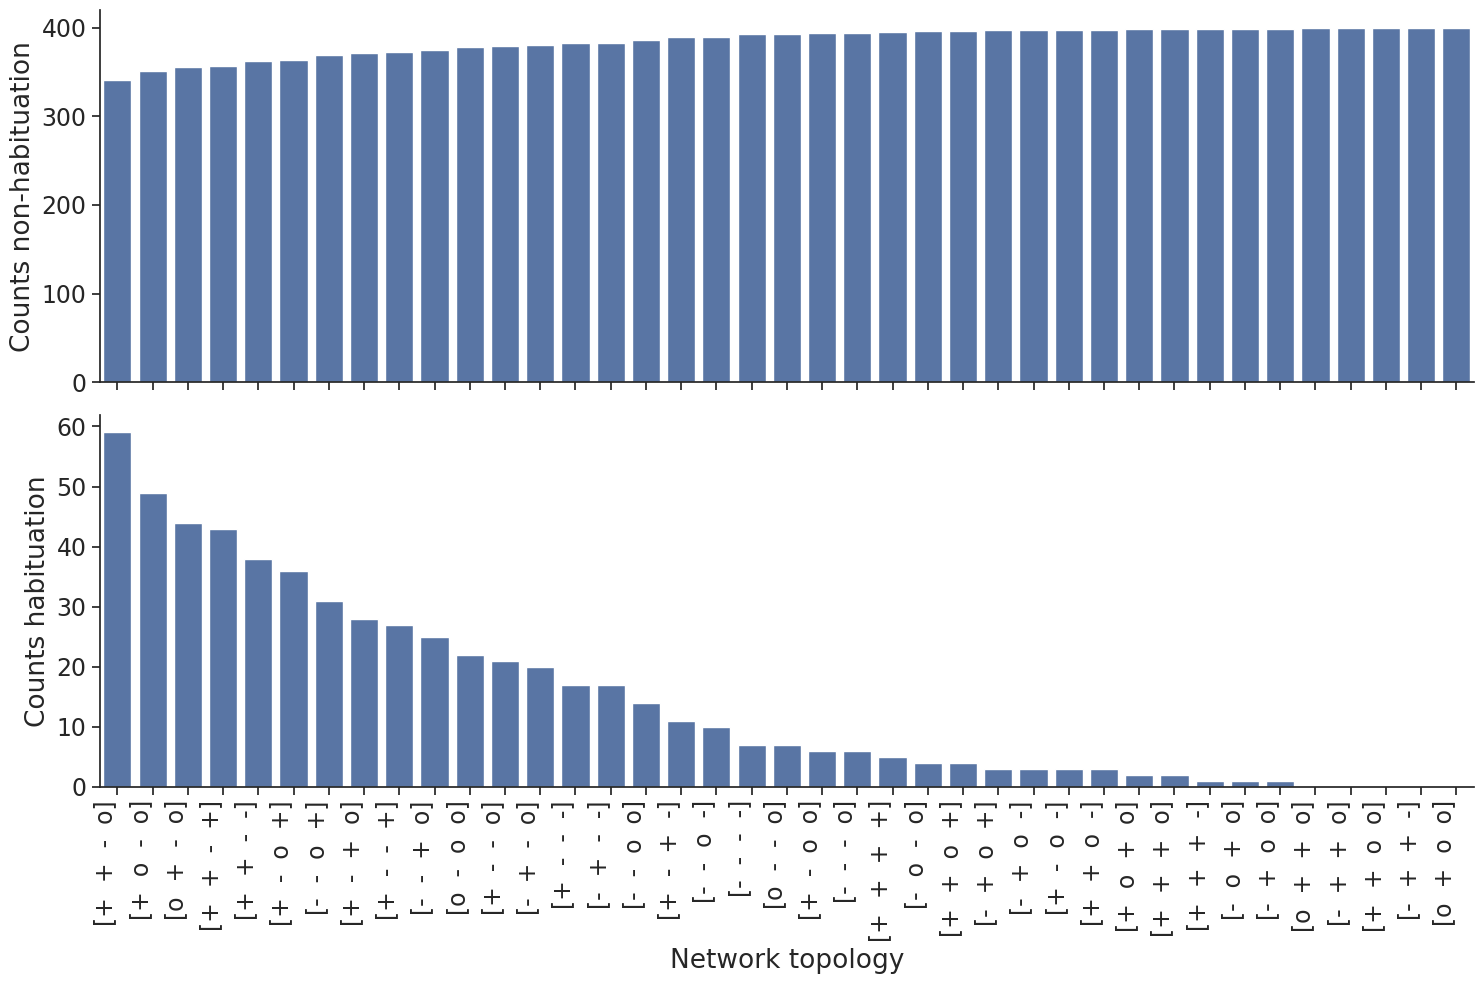

In [104]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
sns.barplot(x='Network topology', y='Counts non-habituation', data=data_barplot_network, ax=axes[0])
sns.barplot(x='Network topology', y='Counts habituation', data=data_barplot_network, ax=axes[1])
sns.set_theme(style="ticks")
axes[0].set_xticklabels([])
axes[0].set_xlabel('')
axes[1].set_xticks(range(len(row_labels)))  # Set x-tick positions
axes[1].set_xticklabels(row_labels, rotation=90, ha='right')  # Set custom labels
#axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
sns.despine(ax=axes[0])
sns.despine(ax=axes[1])

axes[1].set_xlabel('Network topology', fontsize = 19)
axes[0].set_ylabel('Counts non-habituation', fontsize = 19)
axes[1].set_ylabel('Counts habituation', fontsize = 19)
axes[0].tick_params(axis='y', labelsize=17)
axes[1].tick_params(axis='x', labelsize=17)
axes[1].tick_params(axis='y', labelsize=17)

plt.tight_layout()
plt.show()

In [105]:
sort_extinput = list(data_barplot_extinput['GRN external inputs'].values)
sort_network = list(data_barplot_network['Network topology'].values)

glue_hab = counts_hab_all.pivot(index="Network topology", columns="External input proportionality", values="Count")

# Create a sorting key column based on the custom order
glue_hab['sort_key'] = glue_hab.index.map(lambda x: sort_network.index(x) if x in sort_network else len(sort_network))
# Sort the DataFrame by the sorting key and drop the sorting key column
sorted_glue_hab = glue_hab.sort_values(by='sort_key').drop(columns='sort_key')
glue_reordered_hab = sorted_glue_hab[sort_extinput]


glue_no_hab = counts_no_hab.pivot(index="Network topology", columns="External input proportionality", values="Count")

# Create a sorting key column based on the custom order
glue_no_hab['sort_key'] = glue_no_hab.index.map(lambda x: sort_network.index(x) if x in sort_network else len(sort_network))
# Sort the DataFrame by the sorting key and drop the sorting key column
sorted_glue_no_hab = glue_no_hab.sort_values(by='sort_key').drop(columns='sort_key')
glue_reordered_no_hab = sorted_glue_no_hab[sort_extinput]

In [106]:
sort_network[:11]

['[1. 1. 2. 0.]',
 '[1. 0. 2. 0.]',
 '[0. 1. 2. 0.]',
 '[1. 1. 2. 1.]',
 '[1. 1. 2. 2.]',
 '[1. 2. 0. 1.]',
 '[2. 2. 0. 1.]',
 '[1. 2. 1. 0.]',
 '[1. 2. 2. 1.]',
 '[2. 2. 1. 0.]',
 '[0. 2. 0. 0.]']

In [107]:
glue_reordered_hab

External input proportionality,"nd, -r","-r, -r","-r, nd","+r, -r","-r, +r","+r, +r","nd, +r","+r, nd"
Network topology,,,,,,,,
[1. 1. 2. 0.],28,19,0,10,0,1,0,1
[1. 0. 2. 0.],30,15,0,4,0,0,0,0
[0. 1. 2. 0.],30,14,0,0,0,0,0,0
[1. 1. 2. 1.],23,11,0,8,0,1,0,0
[1. 1. 2. 2.],17,14,0,5,0,1,0,1
[1. 2. 0. 1.],0,6,23,0,3,1,3,0
[2. 2. 0. 1.],0,8,15,0,6,1,1,0
[1. 2. 1. 0.],0,5,23,0,0,0,0,0
[1. 2. 2. 1.],11,3,12,0,0,1,0,0


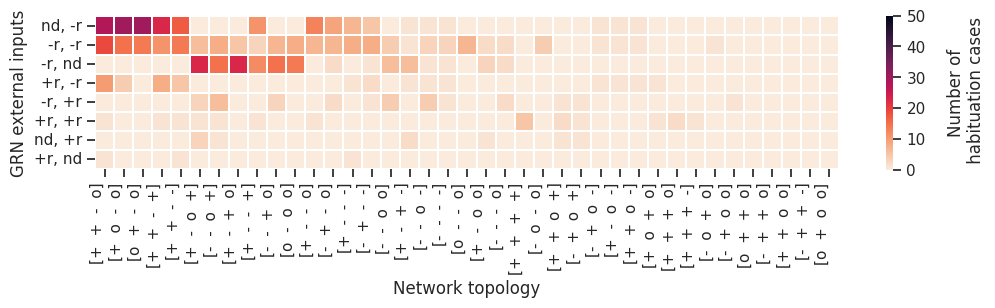

In [108]:
plt.figure(figsize=(12, 10))
heatmap_hab = sns.heatmap(glue_reordered_hab.T, square=True, linewidth = 0.1, cmap = 'rocket_r', vmin=0, vmax=50, cbar_kws={'shrink': 0.2})
heatmap_hab.set_xlabel('Network topology')
heatmap_hab.set_ylabel('GRN external inputs')
heatmap_hab.set_xticks(np.arange(len(row_labels)) + 0.5)  # Shift to align with heatmap cells
heatmap_hab.set_xticklabels(row_labels, rotation=90, ha='right')  # Rotate labels if needed
colorbar = heatmap_hab.collections[0].colorbar
colorbar.set_label('Number of\n habituation cases',  labelpad=15)

plt.show()

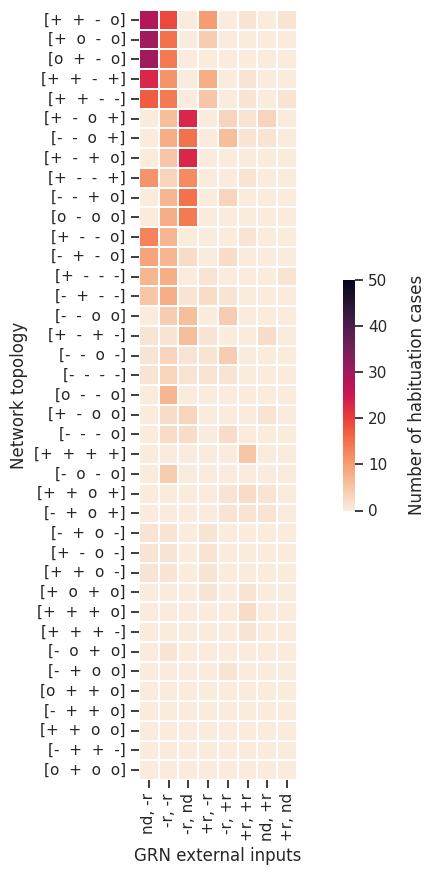

In [109]:
plt.figure(figsize=(12, 10))
heatmap_hab = sns.heatmap(glue_reordered_hab, square=True, linewidth = 0.1, cmap = 'rocket_r', vmin=0, vmax=50, cbar_kws={'shrink': 0.3})
heatmap_hab.set_xlabel('GRN external inputs')
heatmap_hab.set_yticks(np.arange(len(row_labels)) + 0.5)  # Shift to align with heatmap cells
heatmap_hab.set_yticklabels(row_labels, rotation=0, ha='right')  # Rotate labels if needed
colorbar = heatmap_hab.collections[0].colorbar
colorbar.set_label('Number of habituation cases',  labelpad=15)

plt.show()

## 5.  Percentage of habituation cases per each i.c. set

In [110]:
import fastcluster
from scipy.spatial.distance import pdist

In [111]:
df_changed = df.copy(deep=True)
df_changed['Network topology'] = df['Network topology'].apply(lambda x: f'{x}')
df_changed['Parameter set'] = df['Parameter set'].apply(lambda x: f'{x}')
df_changed['External input proportionality'] = df['External input proportionality'].apply(lambda x: ', '.join(map(str, x)))

In [112]:
df_all_ic_habit = df_all_ic[cluster_labels==2].copy(deep=True)
df_all_ic_habit['Network topology'] = df_all_ic['Network topology'].apply(lambda x: f'{x}')
df_all_ic_habit['Parameter set'] = df_all_ic['Parameter set'].apply(lambda x: f'{x}')
df_all_ic_habit['External input proportionality'] = df_all_ic['External input proportionality'].apply(lambda x: ', '.join(map(str, x)))

In [113]:
#Assuming df_big and df_subset are your dataframes and the common columns are 'col1', 'col2', 'col3'
common_columns = ['Network topology', 'Parameter set', 'External input proportionality']
# Merge df_big with df_subset on the common columns
df_changed['original_index'] = df_changed.index
result_df = df_changed.merge(df_all_ic_habit[common_columns], on=common_columns, how='inner')
result_df.set_index('original_index', inplace=True)

In [140]:
result_df

,Network topology,Parameter set,External input proportionality,Initial conditions,Features,Label
original_index,,,,,,
10325,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd","[0.0, 0.0]",4182.0,2
10326,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd","[0.0, 5.0]",7256.0,1
10327,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd","[0.0, 10.0]",7256.0,1
10328,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd","[0.0, 15.0]",7256.0,1
10329,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd","[0.0, 20.0]",7256.0,1
...,...,...,...,...,...,...
386120,[2. 2. 2. 2.],[-2.00131765 -1.29295683 -0.75820084 -1.16680163],"-r, -r","[20.0, 0.0]",6906.0,1
386121,[2. 2. 2. 2.],[-2.00131765 -1.29295683 -0.75820084 -1.16680163],"-r, -r","[20.0, 5.0]",6906.0,1
386122,[2. 2. 2. 2.],[-2.00131765 -1.29295683 -0.75820084 -1.16680163],"-r, -r","[20.0, 10.0]",3800.0,2


In [141]:
features = np.stack(result_df['Features'].values)
scaled_features = zscore(features)
scaled_features = scaled_features.reshape((len(scaled_features), 1))
scaled_features.shape

(14250, 1)

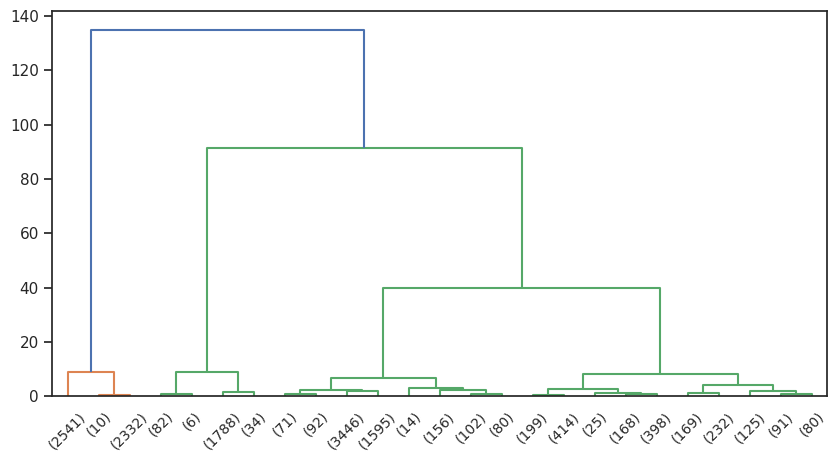

In [142]:
# Use fastcluster's linkage_vector
plt.figure(figsize=(10, 5))
ward_clustering = fastcluster.linkage(scaled_features, method="ward")

# Generate the dendrogram
R = dendrogram(ward_clustering, p=25, truncate_mode='lastp')
plt.show()

In [143]:
# Choose a threshold distance based on the dendrogram
threshold_distance = 100

# Cut the dendrogram to get cluster labels
cluster_labels = fcluster(ward_clustering, threshold_distance, criterion='distance')

result_df['Label'] = cluster_labels

In [144]:
clustering, clustering_counts = np.unique(cluster_labels, return_counts = True)
probs = clustering_counts/np.sum(clustering_counts)

In [145]:
non_habit_idx = list(result_df[result_df['Label']==1].index.values)
habit_idx = list(result_df[result_df['Label']==2].index.values)

In [146]:
non_habit_result_df = result_df.loc[non_habit_idx]
non_habit_result_df

,Network topology,Parameter set,External input proportionality,Initial conditions,Features,Label
original_index,,,,,,
10326,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd","[0.0, 5.0]",7256.0,1
10327,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd","[0.0, 10.0]",7256.0,1
10328,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd","[0.0, 15.0]",7256.0,1
10329,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd","[0.0, 20.0]",7256.0,1
10332,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd","[5.0, 10.0]",7256.0,1
...,...,...,...,...,...,...
386114,[2. 2. 2. 2.],[-2.00131765 -1.29295683 -0.75820084 -1.16680163],"-r, -r","[10.0, 20.0]",6906.0,1
386115,[2. 2. 2. 2.],[-2.00131765 -1.29295683 -0.75820084 -1.16680163],"-r, -r","[15.0, 0.0]",6906.0,1
386119,[2. 2. 2. 2.],[-2.00131765 -1.29295683 -0.75820084 -1.16680163],"-r, -r","[15.0, 20.0]",6906.0,1


In [147]:
habit_result_df = result_df.loc[habit_idx]
habit_result_df_index = habit_result_df.reset_index()
habit_result_df_index.loc[2973]

original_index                                                               154377
Network topology                                                      [1. 1. 2. 0.]
Parameter set                     [ 3.40225406  0.5490615  -2.617512    0.        ]
External input proportionality                                               nd, -r
Initial conditions                                                      [0.0, 10.0]
Features                                                                     4182.0
Label                                                                             2
Name: 2973, dtype: object

In [148]:
habit_result_df['Initial conditions'] = habit_result_df['Initial conditions'].apply(lambda x: f'{x}')
grouped_data = habit_result_df.groupby('Initial conditions').size().reset_index(name='Counts')

In [149]:
grouped_data['ic_0'] = np.stack(grouped_data['Initial conditions'].apply(lambda x: np.fromstring(x.strip('[] ').replace('  ', ' '), sep=' ')).values)[:,0]
grouped_data['ic_1'] = np.stack(grouped_data['Initial conditions'].apply(lambda x: np.fromstring(x.strip('[] ').replace('  ', ' '), sep=' ')).values)[:,1]

In [150]:
grouped_data

,Initial conditions,Counts,ic_0,ic_1
0,[ 0. 10.],346,0.0,10.0
1,[ 0. 15.],346,0.0,15.0
2,[ 0. 20.],346,0.0,20.0
3,[ 5. 10.],422,5.0,10.0
4,[ 5. 15.],365,5.0,15.0
5,[ 5. 20.],356,5.0,20.0
6,[0. 0.],321,0.0,0.0
7,[0. 5.],347,0.0,5.0
8,[10. 0.],244,10.0,0.0
9,[10. 5.],304,10.0,5.0


In [151]:
mapping = {5: 1, 10: 2, 15: 3, 20: 4}

# Replace values using the mapping
grouped_data['ic_0'] = grouped_data['ic_0'].replace(mapping).astype(int)
grouped_data['ic_1'] = grouped_data['ic_1'].replace(mapping).astype(int)

In [152]:
rows, cols = 5, 5  # Example size, adjust as needed
matrix_ic = np.zeros((rows, cols))

# Fill the matrix using the DataFrame
for _, row in grouped_data.iterrows():
    matrix_ic[row['ic_0'], row['ic_1']] = row['Counts']

In [153]:
custom_labels = [0, 5, 10, 15, 20]

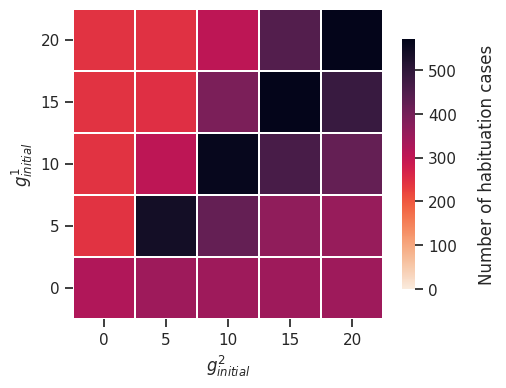

In [155]:
plt.figure(figsize=(5, 5))
heatmap_hab_ic = sns.heatmap(matrix_ic, square=True, linewidth = 0.1, vmin=0, vmax=570, cmap = 'rocket_r', cbar_kws={'shrink': 0.65})
heatmap_hab_ic.set_xlabel('$g_{initial}^2$')
heatmap_hab_ic.set_ylabel('$g_{initial}^1$')
heatmap_hab_ic.invert_yaxis()
heatmap_hab_ic.set_xticks(np.arange(len(custom_labels)) + 0.5)  # Shift to align with heatmap cells
heatmap_hab_ic.set_xticklabels(custom_labels)  # Rotate labels if needed
heatmap_hab_ic.set_yticks(np.arange(len(custom_labels)) + 0.5)  # Shift to align with heatmap cells
heatmap_hab_ic.set_yticklabels(custom_labels, rotation=0, ha='right')  # Rotate labels if needed
colorbar = heatmap_hab_ic.collections[0].colorbar
colorbar.set_label('Number of habituation cases',  labelpad=15)
#sns.color_palette(

Now we want to check the phase portrait of a specific set of network topologies with external inputs

In [157]:
habit_result_df

,Network topology,Parameter set,External input proportionality,Initial conditions,Features,Label
original_index,,,,,,
10325,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd",[0. 0.],4182.0,2
10330,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd",[5. 0.],4182.0,2
10331,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd",[5. 5.],4182.0,2
10335,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd",[10. 0.],4182.0,2
10336,[0. 2. 0. 0.],[ 0. -2.61965983 0. 0. ],"-r, nd",[10. 5.],4182.0,2
...,...,...,...,...,...,...
386117,[2. 2. 2. 2.],[-2.00131765 -1.29295683 -0.75820084 -1.16680163],"-r, -r",[15. 10.],3619.0,2
386118,[2. 2. 2. 2.],[-2.00131765 -1.29295683 -0.75820084 -1.16680163],"-r, -r",[15. 15.],3527.0,2
386122,[2. 2. 2. 2.],[-2.00131765 -1.29295683 -0.75820084 -1.16680163],"-r, -r",[20. 10.],3800.0,2


In [158]:
my_net_list = sort_network[:11]
my_net_list[5:]

['[1. 2. 0. 1.]',
 '[2. 2. 0. 1.]',
 '[1. 2. 1. 0.]',
 '[1. 2. 2. 1.]',
 '[2. 2. 1. 0.]',
 '[0. 2. 0. 0.]']

In [159]:
sort_extinput

['nd, -r',
 '-r, -r',
 '-r, nd',
 '+r, -r',
 '-r, +r',
 '+r, +r',
 'nd, +r',
 '+r, nd']

In [160]:
group_1 = habit_result_df[habit_result_df['Network topology'].isin(my_net_list[0:5])]
group_1 = group_1[group_1['External input proportionality']== sort_extinput[0]]

In [161]:
group_2 = habit_result_df[habit_result_df['Network topology'].isin(my_net_list[0:5])]
group_2 = group_2[group_2['External input proportionality']== sort_extinput[1]]

In [162]:
group_3 = habit_result_df[habit_result_df['Network topology'].isin(my_net_list[5:])]
group_3 = group_3[group_3['External input proportionality']== sort_extinput[1]]

In [163]:
group_4 = habit_result_df[habit_result_df['Network topology'].isin(my_net_list[5:])]
group_4 = group_4[group_4['External input proportionality']== sort_extinput[2]]

In [173]:
group = group_4
group_1

,Network topology,Parameter set,External input proportionality,Initial conditions,Features,Label
original_index,,,,,,
70176,[1. 0. 2. 0.],[ 1.88960007 0. -2.82365983 0. ],"nd, -r",[0. 5.],4182.0,2
70177,[1. 0. 2. 0.],[ 1.88960007 0. -2.82365983 0. ],"nd, -r",[ 0. 10.],4182.0,2
70178,[1. 0. 2. 0.],[ 1.88960007 0. -2.82365983 0. ],"nd, -r",[ 0. 15.],4182.0,2
70179,[1. 0. 2. 0.],[ 1.88960007 0. -2.82365983 0. ],"nd, -r",[ 0. 20.],4182.0,2
70181,[1. 0. 2. 0.],[ 1.88960007 0. -2.82365983 0. ],"nd, -r",[5. 5.],4182.0,2
...,...,...,...,...,...,...
329989,[1. 1. 2. 2.],[ 1.72753656 1.38657265 -1.06131529 -1.88631573],"nd, -r",[10. 20.],4182.0,2
329993,[1. 1. 2. 2.],[ 1.72753656 1.38657265 -1.06131529 -1.88631573],"nd, -r",[15. 15.],4182.0,2
329994,[1. 1. 2. 2.],[ 1.72753656 1.38657265 -1.06131529 -1.88631573],"nd, -r",[15. 20.],4182.0,2


In [174]:
grouped_group_1 = group.groupby('Initial conditions').size().reset_index(name='Counts')
grouped_group_1['ic_0'] = np.stack(grouped_group_1['Initial conditions'].apply(lambda x: np.fromstring(x.strip('[] ').replace('  ', ' '), sep=' ')).values)[:,0]
grouped_group_1['ic_1'] = np.stack(grouped_group_1['Initial conditions'].apply(lambda x: np.fromstring(x.strip('[] ').replace('  ', ' '), sep=' ')).values)[:,1]
mapping = {5: 1, 10: 2, 15: 3, 20: 4}
# Replace values using the mapping
grouped_group_1['ic_0'] = grouped_group_1['ic_0'].replace(mapping).astype(int)
grouped_group_1['ic_1'] = grouped_group_1['ic_1'].replace(mapping).astype(int)

rows, cols = 5, 5  # Example size, adjust as needed
matrix_ic = np.zeros((rows, cols))

# Fill the matrix using the DataFrame
for _, row in grouped_group_1.iterrows():
    matrix_ic[row['ic_0'], row['ic_1']] = row['Counts']

custom_labels = [0, 5, 10, 15, 20]

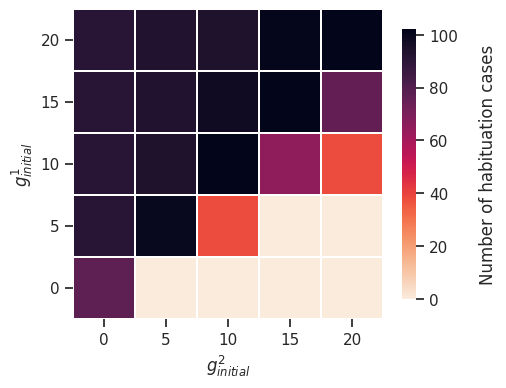

In [175]:
plt.figure(figsize=(5, 5))
heatmap_hab_ic = sns.heatmap(matrix_ic, square=True, linewidth = 0.1, cmap = 'rocket_r', cbar_kws={'shrink': 0.7})
heatmap_hab_ic.set_xlabel('$g_{initial}^2$')
heatmap_hab_ic.set_ylabel('$g_{initial}^1$')
heatmap_hab_ic.invert_yaxis()
heatmap_hab_ic.set_xticks(np.arange(len(custom_labels)) + 0.5)  # Shift to align with heatmap cells
heatmap_hab_ic.set_xticklabels(custom_labels)  # Rotate labels if needed
heatmap_hab_ic.set_yticks(np.arange(len(custom_labels)) + 0.5)  # Shift to align with heatmap cells
heatmap_hab_ic.set_yticklabels(custom_labels, rotation=0, ha='right')  # Rotate labels if needed
colorbar = heatmap_hab_ic.collections[0].colorbar
colorbar.set_label('Number of habituation cases',  labelpad=15)
#sns.color_palette(

In [77]:
ic_list = result_df['Initial conditions'].apply(lambda x: f'{x}')
ic_order = list(ic_list.values[:25])

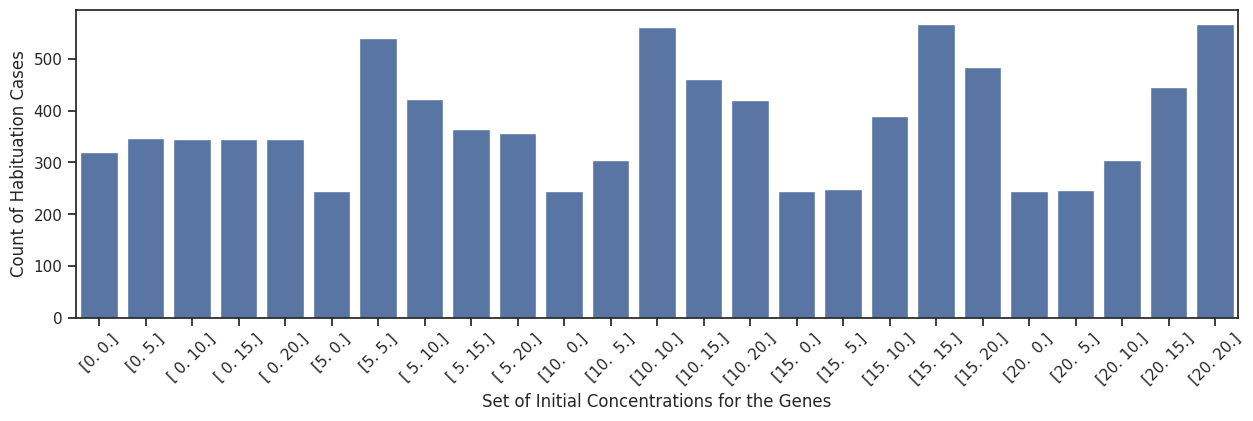

In [78]:
plt.figure(figsize=(15, 4))
# Plotting with seaborn
sns.barplot(x='Initial conditions', y='Counts', data=grouped_data, order = ic_order)

plt.xlabel('Set of Initial Concentrations for the Genes')
plt.ylabel('Count of Habituation Cases')
plt.xticks(rotation=45)
plt.show()

In [79]:
probs[[-1,0]]

array([0.65733333, 0.34266667])

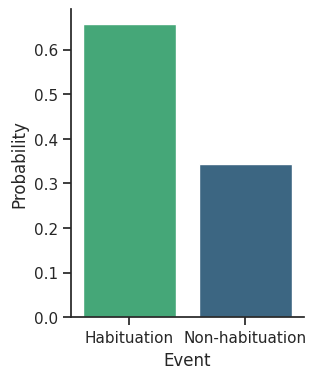

In [80]:
data = {
    'Event': ['Habituation', 'Non-habituation'],
    'Probability': list(probs[[-1,0]])
}
df_prob_hab = pd.DataFrame(data)

plt.figure(figsize=(3, 4))
sns.barplot(x='Event', y='Probability', hue = 'Event', data=df_prob_hab, palette='viridis_r')
sns.despine()
plt.show()

In [59]:
check_idx = habit_idx

In [47]:
title = 'Cluster 1'
n_samp = 10

V_all, V_th_all, genes_all_spike, genes_all_base, param_sets, ext_inputs, ics, random_cluster_list = create_traj_to_plot(N, df.loc[check_idx], n_samp)

[ 91590  17733 158510 378310 152520 367115 264502 217186 348345  71721
  76785 341180 335927 213983  78387 340335 158586 129504 212104 154917
 312192 333334  91192 315721  17704 315720  71110 347914 239144 238133
 227792 266301 348327 211705 219391 324440 364579 234328  72380 266309
 215983  98123 324245 284313  18138 190103  94397  90796 218179  76780
  18109  71515 327395  92100 337927 325597 152500 152575 128320 337932
 159996 363776 265907  97585 327122  70185 162714 266328  94985 318716
 347908 333333  74316 364394 238325 275146 105732  92596 154905 233926
 190307 211577  95780 349176  90995  19327 313505 266303 263334 211784
  93395 325915 348989 263484 151310 342585 217777 128115 312100  73596]


KeyboardInterrupt: 

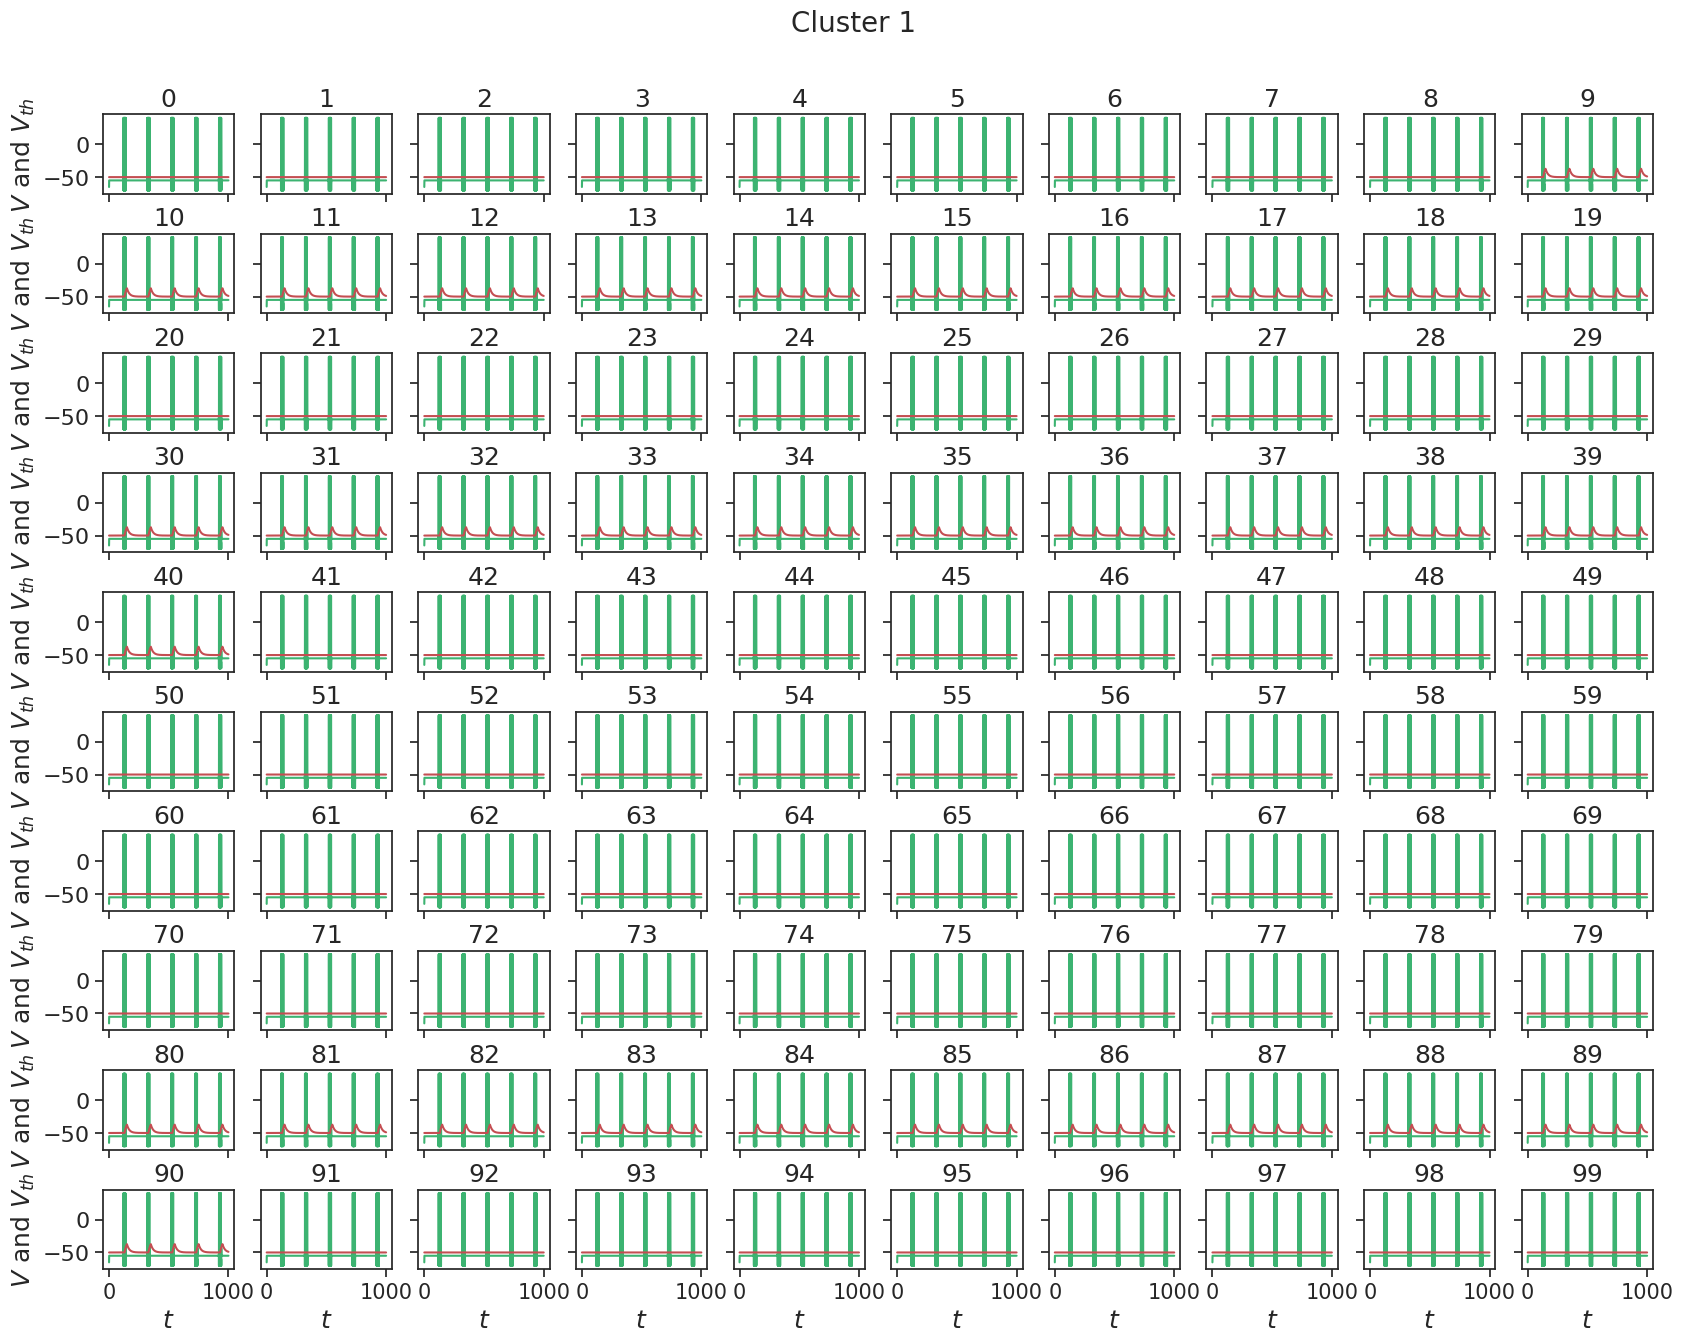

In [146]:
what = 'V'
make_traj_grid_plots(V_all, V_th_all, genes_all_spike, param_sets, ext_inputs, ics, title, what, n_samp, random_cluster_list)

In [141]:
title = 'Cluster 2'
n_samp = 10

V_all, V_th_all, genes_all_spike, genes_all_base, param_sets, ext_inputs, ics, random_cluster_list = create_traj_to_plot(N, df.loc[check_idx], n_samp)

[220924 342095 254199 151125  77041  89829 113297  69266 140843 351356
 254915 311691 206691 125301 117616 170179 322228 325649  53387 191379
 158570 103929 277569 279373 145136 332618 261819  35917 264569 274708
 187343  35136 161226 153133 321482 240910  23860 207586 154330 380604
 104424 208335 224413  22786  22048  76998 327819 207200 161048 111613
 306785 233108 267148 278284  79658 374660 254008  34331  54202 181270
 352610   1844 200011   6862 260529 233418 270086 301701 289895 118656
 256434 192066 150038 209522  35682 210739 109367 301122 183170 290006
 147091 290603 317244  86057 182416 125625 312425 113419  80180 144704
 341043 346454 384865 316146 109694 335533 372074  97707 112563  81943]


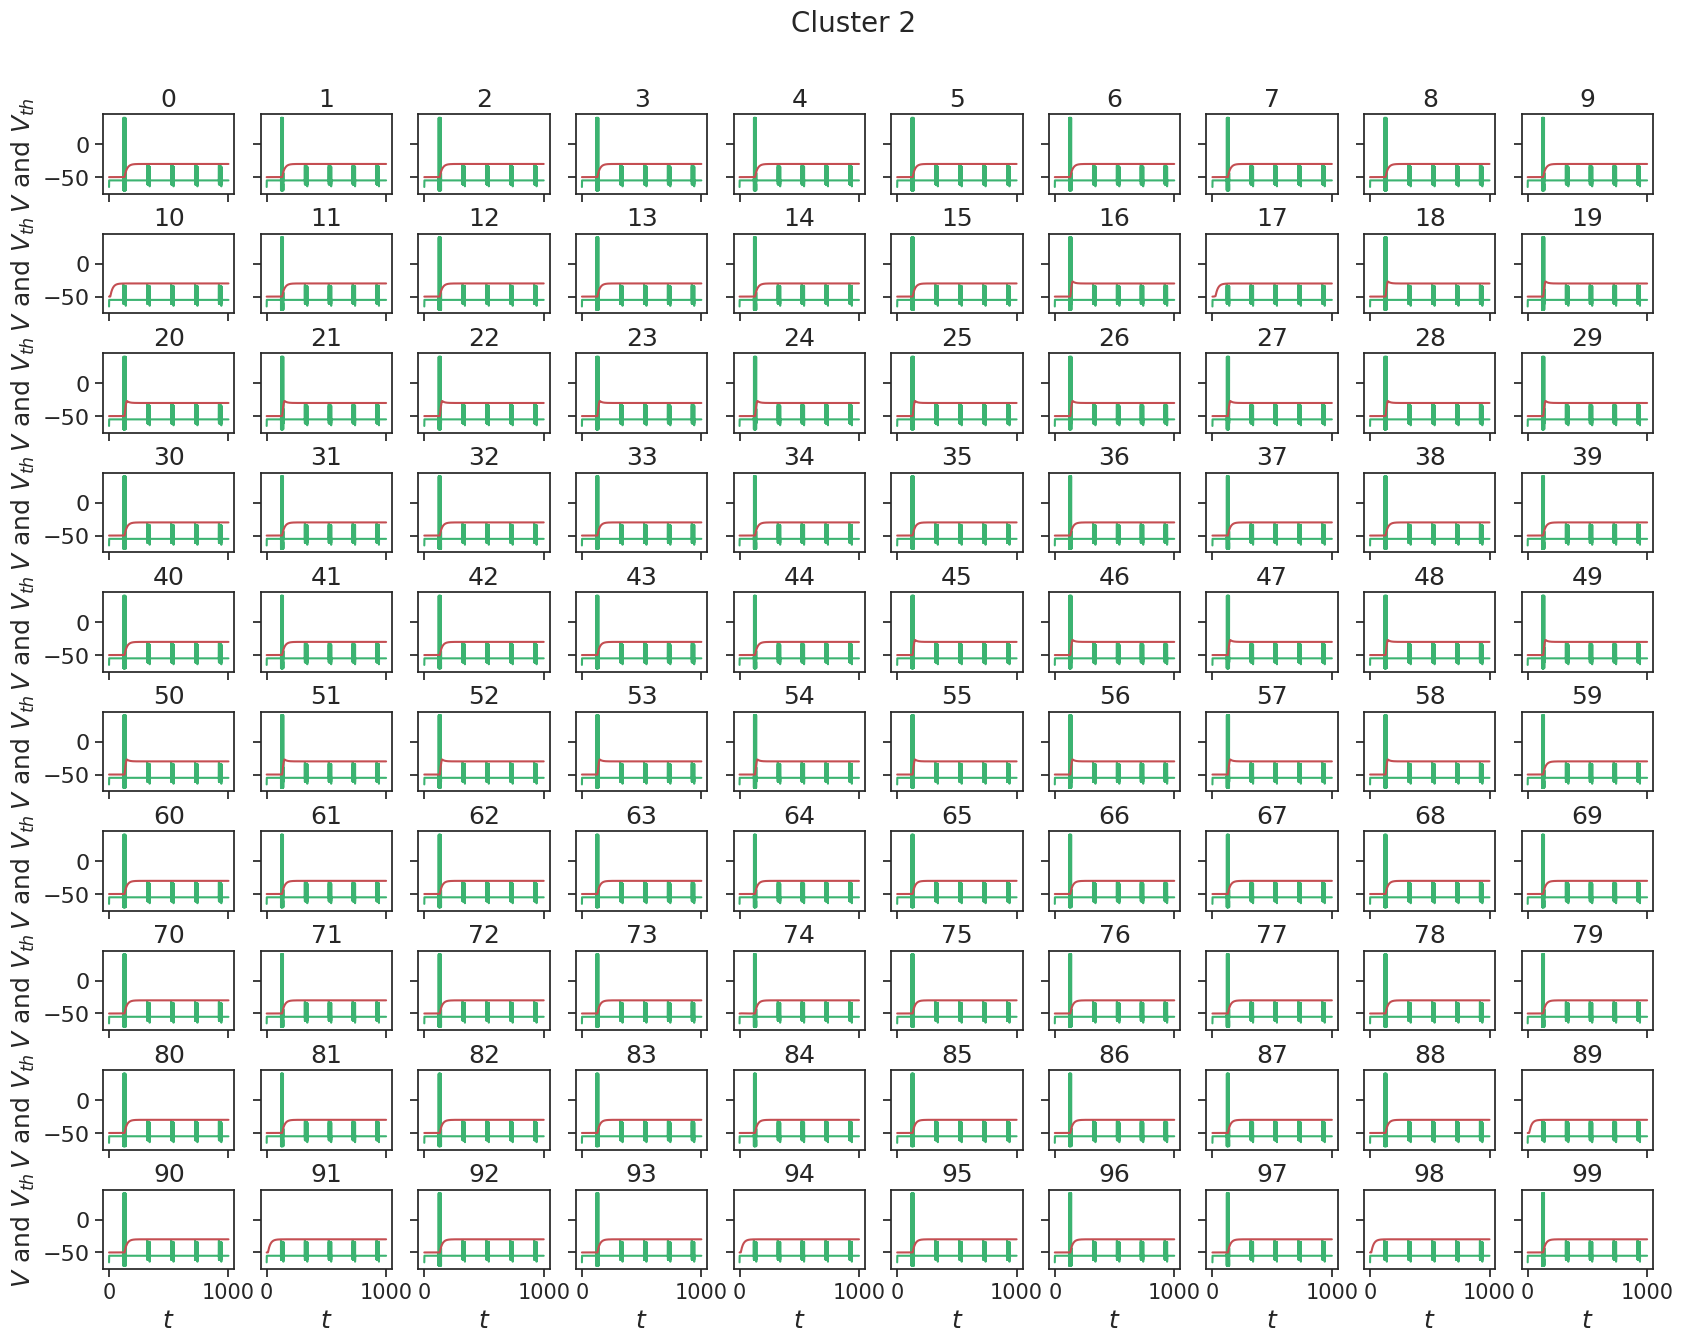

In [142]:
what = 'V'
make_traj_grid_plots(V_all, V_th_all, genes_all_spike, param_sets, ext_inputs, ics, title, what, n_samp, random_cluster_list)

## 6.  Plotting random instances from each cluster to understand if the clustering has worked

In [37]:
ic_list = np.linspace(0,20,5)

#### 6.1. Cluster 1: No Habituation

In [38]:
cluster_number = 1
V_all, V_th_all, genes_all_spike, genes_all_base, param_sets, ext_inputs = create_traj_to_plot_all_ic(2,  df_all_ic, cluster_labels, cluster_number, ic_list)

[13246  1528 15411  6147  7736 11558 13074 15086  8694  2900]


/home/sofpach/.local/lib/python3.8/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


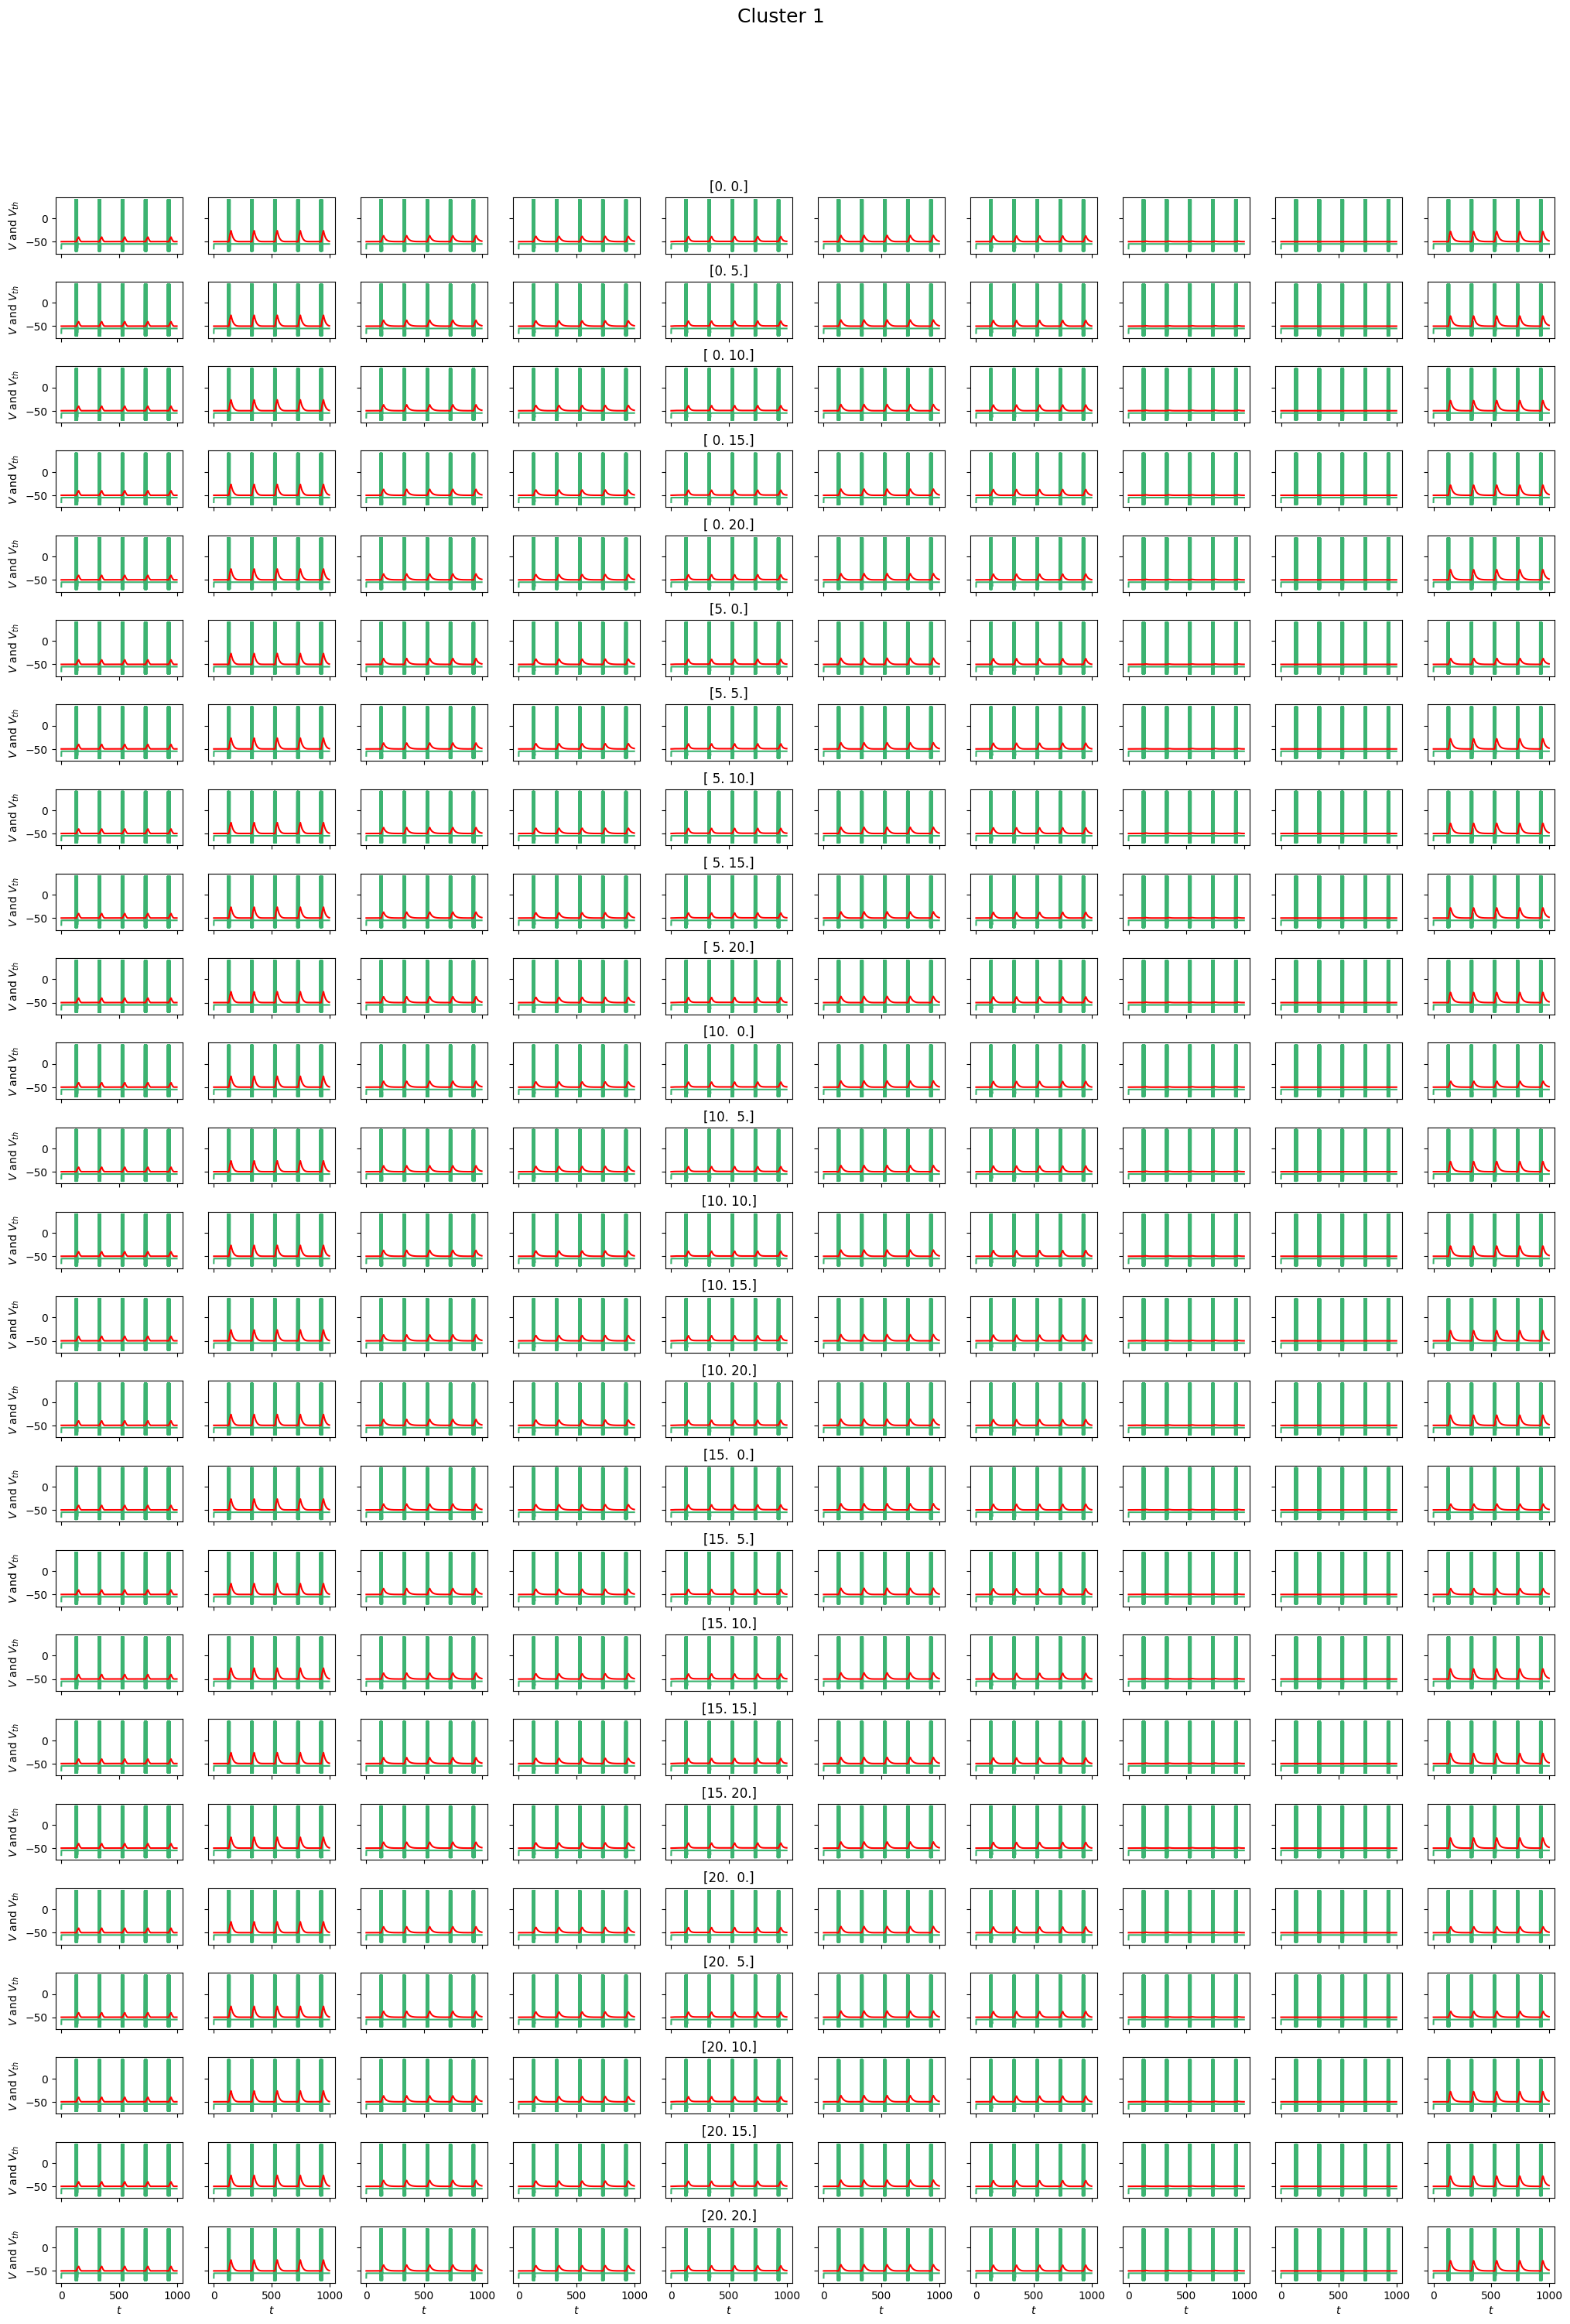

In [39]:
what = 'V'
make_traj_grid_plots_all_ic(V_all, V_th_all, genes_all_base, param_sets, ext_inputs, 'Cluster 1', what, ic_list)

#### 6.2. Cluster 2: Habituation

In [40]:
cluster_number = 2
V_all, V_th_all, genes_all_spike, genes_all_base, param_sets, ext_inputs = create_traj_to_plot_all_ic(2,  df_all_ic, cluster_labels, cluster_number, ic_list)

[ 7981 12452  9525  8468 14684  7725  9436  7867 12428 12977]


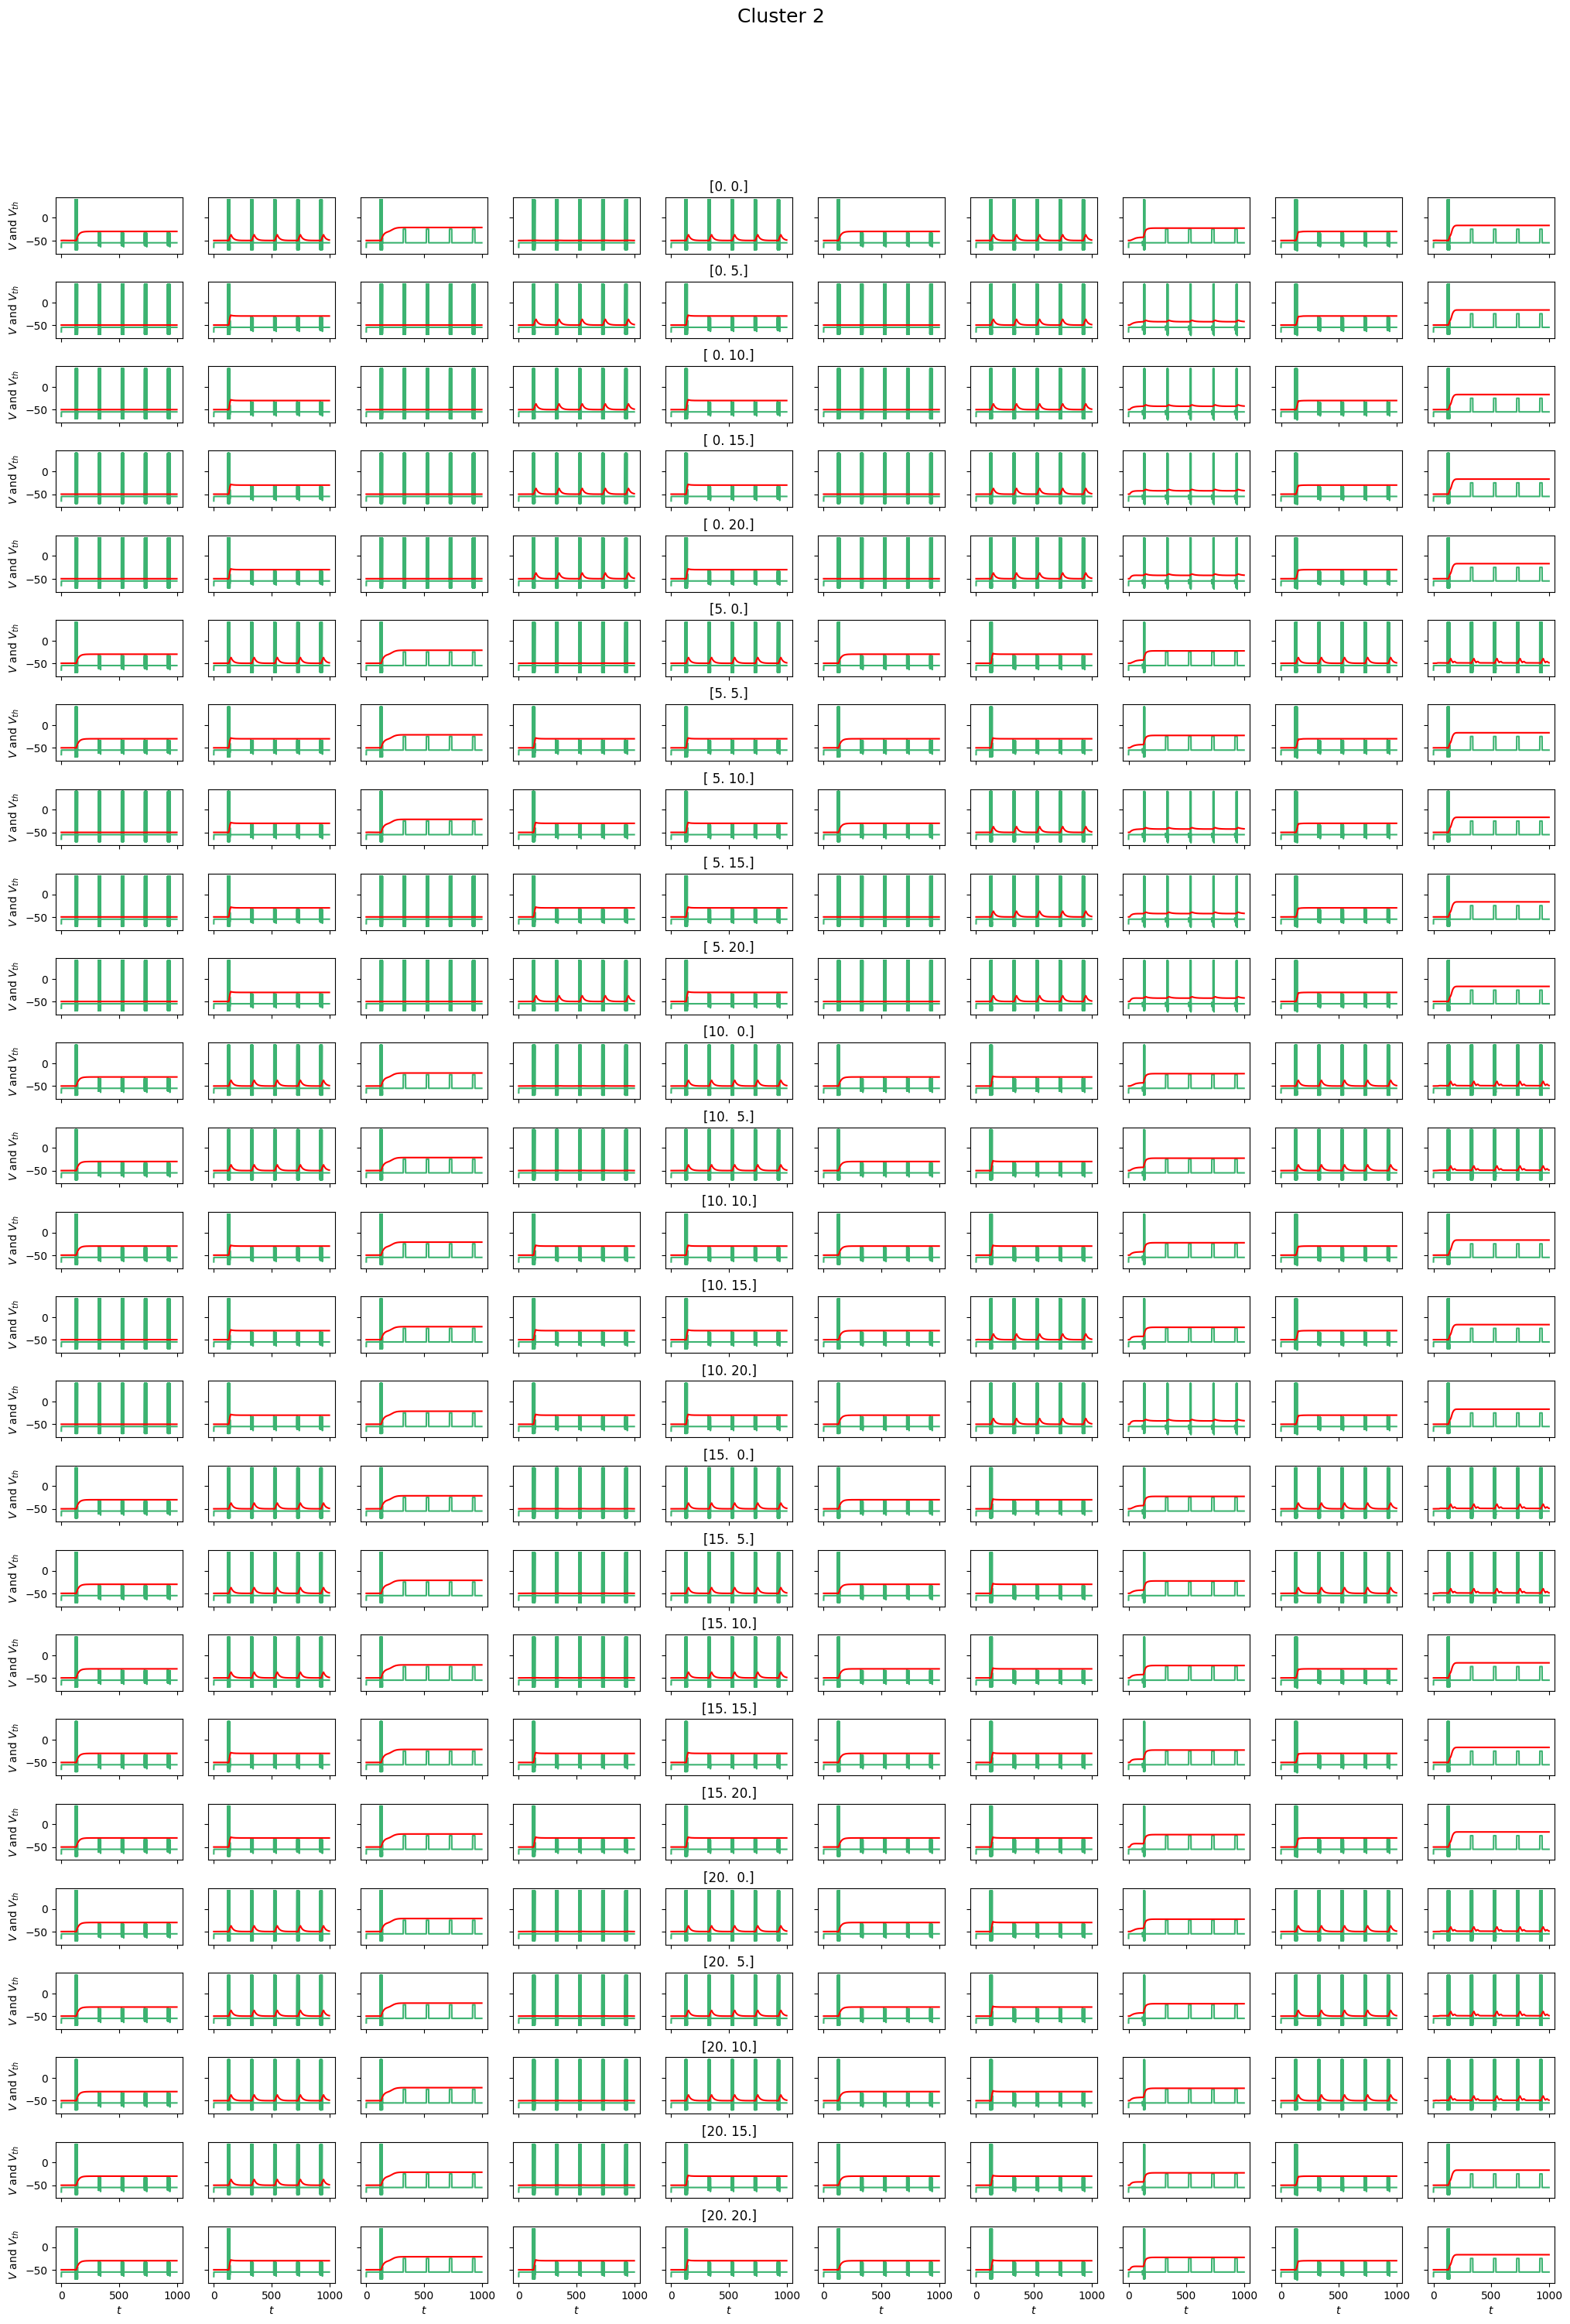

In [41]:
what = 'V'
make_traj_grid_plots_all_ic(V_all, V_th_all, genes_all_base, param_sets, ext_inputs, 'Cluster 2', what, ic_list)